In [29]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [30]:
# %%bash
# pwd
# ls -t ../../nc_storage
# squeue --user=${USER} --start

In [31]:
ds = xr.open_dataset("../output/grids/a3d_grids_2015.nc") # Experiment
# ds = xr.open_dataset("../../PRODUCTION/2015_WN/output/grids/a3d_grids_2015.nc") # WindNinja 2016
# ds = ds.isel(time=slice(0, 279))

In [32]:
# Trim grids
n_trim = 15 # 15 for 1 km simulations
ds = ds.isel(easting=slice(n_trim, -n_trim))
ds = ds.isel(northing=slice(n_trim, -n_trim))
ds

<xarray.Dataset>
Dimensions:                (easting: 168, northing: 108, time: 435)
Coordinates:
  * time                   (time) datetime64[ns] 2015-01-01T01:00:00 ... 2015-01-19T03:00:00
  * northing               (northing) float32 -109500.0 -108500.0 ... -2500.0
  * easting                (easting) float32 -1542500.0 ... -1375500.0
Data variables:
    dw                     (time, northing, easting) float32 ...
    ERODEDMASS             (time, northing, easting) float32 ...
    ET                     (time, northing, easting) float32 ...
    snd                    (time, northing, easting) float32 ...
    rlds                   (time, northing, easting) float32 ...
    rsds                   (time, northing, easting) float32 ...
    MS_EROSION_DHS         (time, northing, easting) float32 ...
    MS_HNW                 (time, northing, easting) float32 ...
    MS_SETTLING_DHS        (time, northing, easting) float32 ...
    MS_SNOWPACK_RUNOFF     (time, northing, easting) float32 ...
    MS_SNOW_DHS            (time, northing, easting) float32 ...
    MS_SUBL_DHS            (time, northing, easting) float32 ...
    MS_WIND                (time, northing, easting) float32 ...
    pr                     (time, northing, easting) float32 ...
    hur                    (time, northing, easting) float32 ...
    RHO1                   (time, northing, easting) float32 ...
    RHO2                   (time, northing, easting) float32 ...
    RHO3                   (time, northing, easting) float32 ...
    RHO4                   (time, northing, easting) float32 ...
    RHO5                   (time, northing, easting) float32 ...
    SFC_SUBL               (time, northing, easting) float32 ...
    SURF_ALB               (time, northing, easting) float32 ...
    swe                    (time, northing, easting) float32 ...
    ta                     (time, northing, easting) float32 ...
    ts                     (time, northing, easting) float32 ...
    ws                     (time, northing, easting) float32 ...
    WINDEROSIONDEPOSITION  (time, northing, easting) float32 ...
Attributes:
    date_created:              2021-12-17
    creator_name:              erke2265
    source:                    MeteoIO-3.00
    history:                   2021-12-17T19:22:00Z, erke2265@shas0138.rc.int...
    keywords_vocabulary:       AGU Index Terms
    keywords:                  Cryosphere, Mass Balance, Energy Balance, Atmo...
    title:                     Gridded data for various parameters and timesteps
    institution:               colorado.edu
    product_version:           1.0
    Conventions:               CF-1.6,ACDD-1.3
    standard_name_vocabulary:  CF-1.6
    cdm_data_type:             Grid
    geospatial_bounds_crs:     EPSG:3031
    geospatial_bounds:         Polygon ((-1557500.0000000000 -124500.00000000...

In [33]:
# n_finished = len(ds['time'])
# n_total = 366*24
# percent_done = 100 * (n_finished / n_total)
# elapsed_time = 20/60 # hours
# estimated_total_time = elapsed_time / (percent_done *0.01)
# remaining_time = estimated_total_time - elapsed_time

# print("Finished time steps = " + str(n_finished))
# print("Total time steps = " + str(n_total))
# print("Percent done = " + str(percent_done))
# print()

# print("Elapsed time = " + str(elapsed_time) + " hours")
# print("Estimated remaining time = " + str(remaining_time) + " hours")
# print("Estimated total time = " + str(estimated_total_time) + " hours")

# SWE at end of model time period

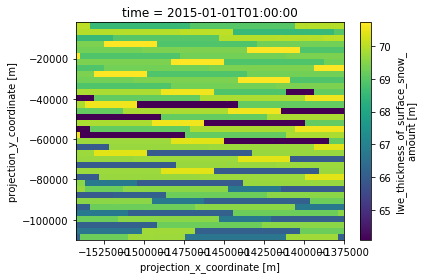

In [34]:
ds['swe'][0,:,:].plot()

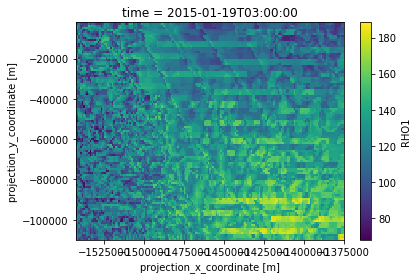

In [35]:
ds['RHO1'][-1,:,:].plot()

# Delta SWE timeseries

In [36]:
# Function to calculate dswe time series
def swe_ts(ds):
    ts = ds['swe'] - ds['swe'].isel(time=0)
    ts = ts.mean(dim='easting').mean(dim='northing') * 1000
    return ts

# Delta SWE map

In [37]:
# Function to calculate timesum of variable
def swe_map(ds):
    dswe_map = ds['swe'].isel(time=-1) - ds['swe'].isel(time=0)
    dswe_map = dswe_map * 1000
    return dswe_map

# Mass Balance Functions

In [38]:
# Function to retrieve time series
def return_ts(ds, var):
    ts = ds[var][dict(time=slice(1,len(ds['time'])))]
    return ts

# Function to retrieve cumulative sum
def return_time_sum(ds, var):
    ts = return_ts(ds, var)
    time_sum = ts.cumsum(dim='time')
    return time_sum

# Function to calculte domain average fields
def return_domain_avg(ds, var):
    ts = return_time_sum(ds, var)
    ts = ts.mean(dim='easting').mean(dim='northing')
    return ts

# Function to calculate mass balance 1 time series
def return_mb1_ts(ds):
    mb = return_domain_avg(ds, 'MS_HNW') - return_domain_avg(ds, 'MS_WIND') - return_domain_avg(ds, 'ET') + return_domain_avg(ds, 'MS_SNOWPACK_RUNOFF')
    return mb

# Function to calculate mass balance 1 map
def return_mb1_map(ds):
    mb = return_time_sum(ds, 'MS_HNW') - return_time_sum(ds, 'MS_WIND') - return_time_sum(ds, 'ET') + return_time_sum(ds, 'MS_SNOWPACK_RUNOFF')
    return mb

# Function to calculate mass balance 2 time series
def return_mb2_ts(ds):
    mb = return_domain_avg(ds, 'pr') - return_domain_avg(ds, 'ET') + return_domain_avg(ds, 'WINDEROSIONDEPOSITION') - return_domain_avg(ds, 'MS_SNOWPACK_RUNOFF')
    # MS_WIND represents the mass suspended in the air. If you want to remove that mass from the mass balance calculations, uncoment the line below. 
#     mb = mb - ds['MS_WIND'][dict(time=slice(1, len(ds['time'])))].mean(dim='northing').mean(dim='easting')
    return mb

# Function to calculate mass balance 2 map
def return_mb2_map(ds):
    mb = return_time_sum(ds, 'pr') - return_time_sum(ds, 'ET') + return_time_sum(ds, 'WINDEROSIONDEPOSITION') - return_time_sum(ds, 'MS_SNOWPACK_RUNOFF')
    # MS_WIND represents the mass suspended in the air. If you want to remove that mass from the mass balance calculations, uncoment the line below. 
#     mb = mb - ds['MS_WIND'][dict(time=slice(1, len(ds['time'])))]
    return mb

# Delta SWE Plots

Max SMB = 15.213013
Mean SMB = 9.270185
Min SMB = 5.470276
Max/Min ratio = 2.781032


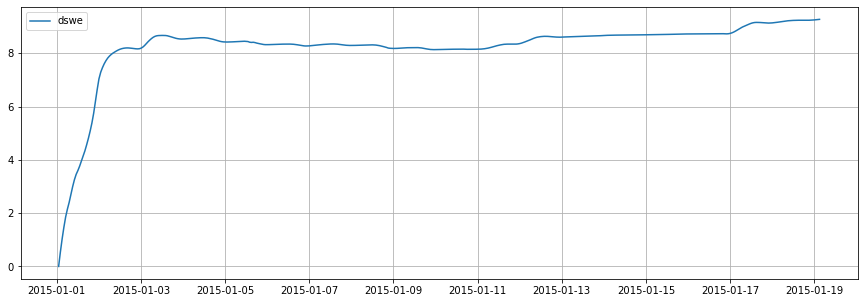

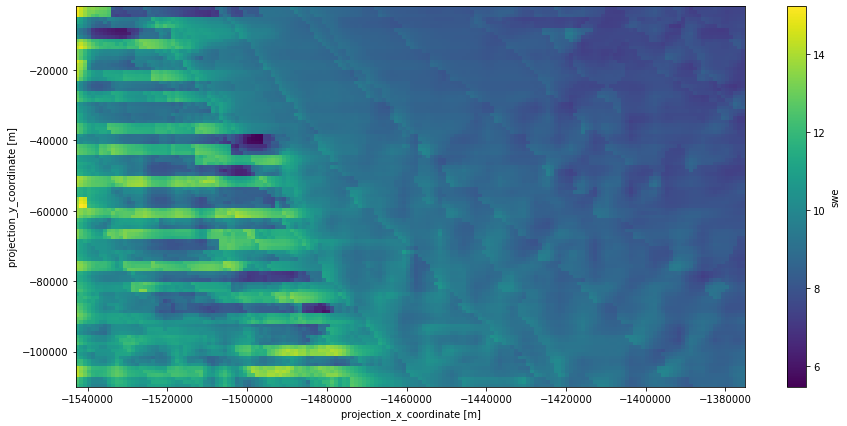

In [39]:
# Calculate time series
dswe_ts = swe_ts(ds)
# mb1_ts = return_mb1_ts(ds)
# mb2_ts = return_mb2_ts(ds)

# Calculate Maps
dswe_map = swe_map(ds)
# mb1_map = return_mb1_map(ds)
# mb2_map = return_mb2_map(ds)

# Plot time series
plt.figure(figsize=(15, 5))
plt.plot(dswe_ts['time'], dswe_ts, label='dswe')
# plt.plot(mb1_ts['time'], mb1_ts, label='mb1')
# plt.plot(mb2_ts['time'], mb2_ts, label='mb2')
plt.grid()
plt.legend()

# # Plot MS_WIND timeseries
# plt.figure(figsize=(15, 5))
# plt.plot(ds['time'], ds['MS_WIND'].mean(dim='easting').mean(dim='northing'))
# plt.grid()
# plt.legend()

# Plots maps
plt.figure(figsize=(15, 7))
dswe_map.plot()
plt.savefig("smb.pdf", dpi=100)

# plt.figure(figsize=(15, 7))
# mb1_map.isel(time=-1).plot()

# plt.figure(figsize=(15, 7))
# mb2_map.isel(time=-1).plot()

# Print max, mean, min SMB
print("Max SMB = " + str(dswe_map.max().values))
print("Mean SMB = " + str(dswe_map.mean().values))
# print("Mean SMB = " + str(mb1_map.isel(time=-1).mean().values))
# print("Mean SMB = " + str(mb2_map.isel(time=-1).mean().values))
print("Min SMB = " + str(dswe_map.min().values))
print("Max/Min ratio = " + str(dswe_map.max().values / dswe_map.min().values))

# # Transect
# plt.figure(figsize=(10, 5))
# dswe_map[29,:].plot()

100.0


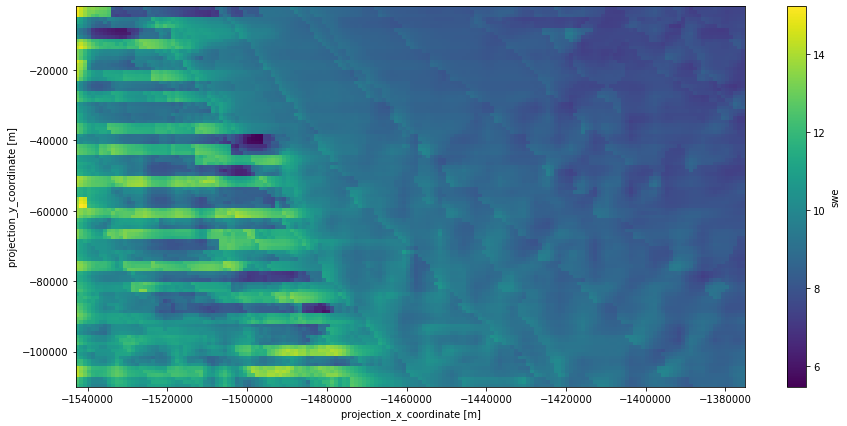

In [40]:
smb_positive = dswe_map.where(dswe_map > 0)
plt.figure(figsize=(15, 7))
smb_positive.plot()

n_nan = np.count_nonzero(~np.isnan(smb_positive))
n_total = smb_positive.shape[0] * smb_positive.shape[1]
print(n_nan / n_total * 100)

# Drifting snow maps

<xarray.DataArray 'WINDEROSIONDEPOSITION' ()>
array(0.42636076, dtype=float32)
<xarray.DataArray 'WINDEROSIONDEPOSITION' ()>
array(0.32720554, dtype=float32)
<xarray.DataArray 'WINDEROSIONDEPOSITION' ()>
array(1.204481, dtype=float32)
Coordinates:
    northing  float32 -59500.0


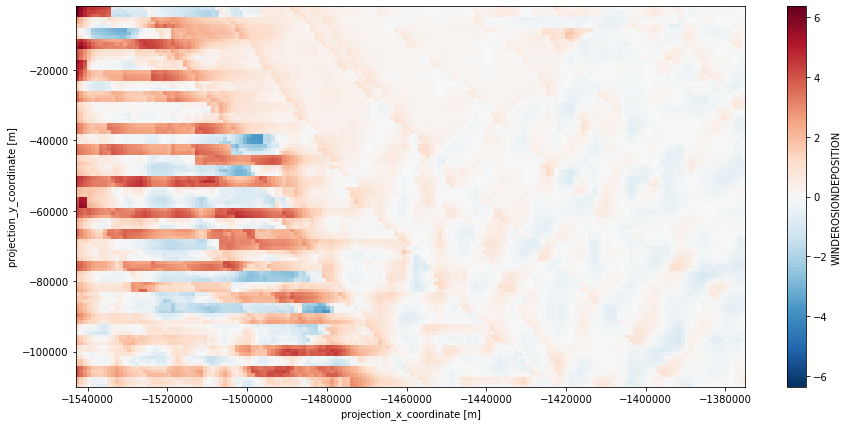

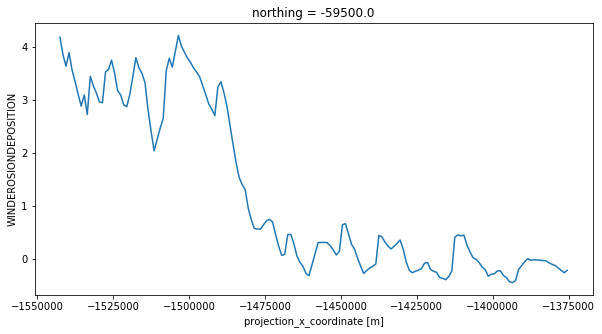

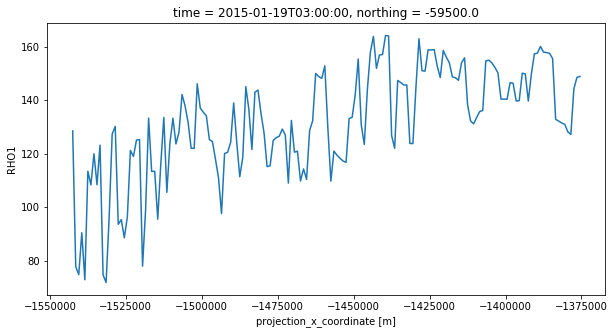

In [41]:
wind_sum = ds['WINDEROSIONDEPOSITION'].sum(dim='time')
plt.figure(figsize=(15, 7))
wind_sum.plot()
print(wind_sum.mean())
print(np.abs(wind_sum).median())
plt.savefig("net_wind_transport.pdf", dpi=100)

# Transect
plt.figure(figsize=(10, 5))
wind_sum[50,:].plot()
print(wind_sum[50,:].mean())

plt.figure(figsize=(10, 5))
ds['RHO1'][-1,50,:].plot()

In [42]:
# plt.figure(figsize=(15, 7))
# ds['ws'].max(dim='time').plot()
# print(ds['ws'].max())

In [43]:
# ds['pr'].sum(dim='time').plot()

In [44]:
# plt.figure(figsize=(15, 7))
# ds['ws'].max(dim='time').plot()

In [45]:
# plt.figure(figsize=(15, 7))
# ds['dw'].mean(dim='time').plot()

In [46]:
# pr_sum = ds['pr'].sum(dim='time')
# plt.figure(figsize=(15, 7))
# pr_sum.plot()
# # plt.savefig("precip.pdf", dpi=100)
# # print(pr_sum.mean())

In [47]:
# plt.figure(figsize=(15, 7))
# # wind_pr = np.abs(wind_sum) / pr_sum
# wind_pr = 100 * (wind_sum / pr_sum)
# wind_pr.plot()
# print(wind_pr.mean())
# plt.figure(figsize=(15, 7))
# plt.hist(wind_pr.values.flatten())
# plt.figure(figsize=(15, 7))
# plt.plot(wind_pr[25,:])

In [48]:
# subl_sum = ds['SFC_SUBL'].sum(dim='time')
# plt.figure(figsize=(15, 7))
# subl_sum.plot()
# plt.savefig("sublimation.pdf", dpi=100)
# print(subl_sum.mean())

In [49]:
# # wn = xr.open_dataset("/scratch/summit/erke2265/antarctic-windninja/nc_files/wn_processed.nc")
# # wn_mean = wn['Wind Speed'].resample(time="1D").mean().mean(dim='easting').mean(dim='northing')
# ws_mean = ds['ws'].mean(dim='time')
# plt.figure(figsize=(15, 7))
# ws_mean.plot()
# # wn_mean.plot()
# # plt.savefig("wind_speed.pdf", dpi=100)
# # print(ws_mean.mean())

# Drifting snow frequency

In [50]:
# erosion = ds['ERODEDMASS'] > 0
# erosion_frequency = 100 * erosion.sum(dim='time') / len(ds['time'])
# plt.figure(figsize=(20, 10))
# erosion_frequency.plot()

In [51]:
# ds['ws'].mean(dim='time').plot()

In [52]:
# ds['ws'].mean(dim='easting').mean(dim='northing').plot()

# Close dataset so it can be opened again without restarting the kernel

In [53]:
ds.close()

In [54]:
# Load DEM
dem = np.flipud(np.loadtxt("/scratch/summit/erke2265/SNOWPACK_WAIS/input/surface-grids/dem.asc", skiprows=6))
dem = dem[n_trim:-n_trim, n_trim:-n_trim]

In [55]:
# Load DEM
dem2 = np.flipud(np.loadtxt("/pl/active/nasa_smb/scratch_bu/SNOWPACK_WAIS/input/surface-grids/dem.asc", skiprows=6))
dem2 = dem2[n_trim:-n_trim, n_trim:-n_trim]

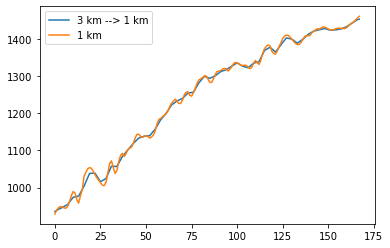

In [56]:
plt.plot(dem[50,:], label='3 km --> 1 km')
plt.plot(dem2[50,:], label='1 km')
plt.legend()